In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [4]:
DATASET_ID = 'buckeye'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'phones.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,audio,rate,spectrogram
0,4.885333,4.988600,w,well,0,0,0,0,s07,0,o,f,s0702b,"[-0.01725538584843273, -0.014406834034244777, ...",16000,"[[2, 2, 2, 2, 2, 2, 2, 0, 44, 79, 95, 86, 81, ..."
1,4.988600,5.114649,eh,well,1,0,1,0,s07,0,o,f,s0702b,"[0.6202093932054022, 0.6635785527737617, 0.653...",16000,"[[4, 4, 4, 4, 4, 174, 166, 164, 162, 160, 159,..."
2,5.114649,5.255262,l,well,2,0,2,0,s07,0,o,f,s0702b,"[-1.0220360017116719, -0.9509200687473669, -0....",16000,"[[5, 5, 5, 5, 5, 170, 156, 156, 154, 151, 149,..."


In [9]:
len(syllable_df)

837643

In [10]:
pd.DataFrame({i:[np.sum(syllable_df.indv == i)] for i in syllable_df.indv.unique()})

,s07,s02,s06,s03,s27,s22,s26,s23,s09,s20,...,s33,s17,s13,s10,s14,s38,s30,s31,s34,s18
0,28011,20740,10647,17421,19227,18335,13275,19643,20054,9179,...,17679,15757,27232,31607,26115,22743,21842,15280,22260,27183


In [11]:
freq_words = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:15]
    .T
)
freq_words

,ah,ih,n,s,eh,t,iy,r,k,l,m,d,ay,w,dh
0,70451,63022,49640,41800,36193,34043,33472,30469,27243,27017,26610,23488,23366,21154,20186


### subset dataframe
- there is some noise in labelling we want to remove

Text(0.5, 1.0, 'min')

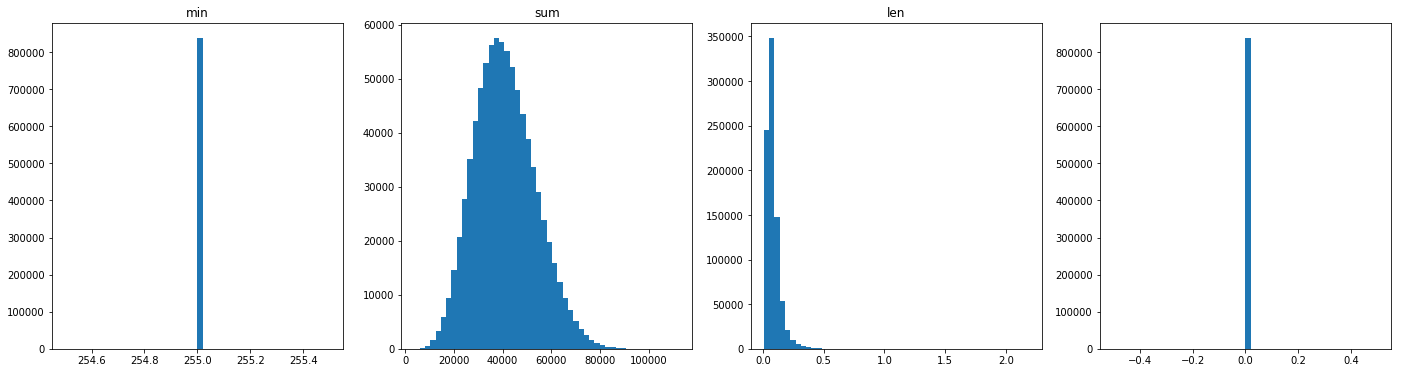

In [12]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('min')

ah


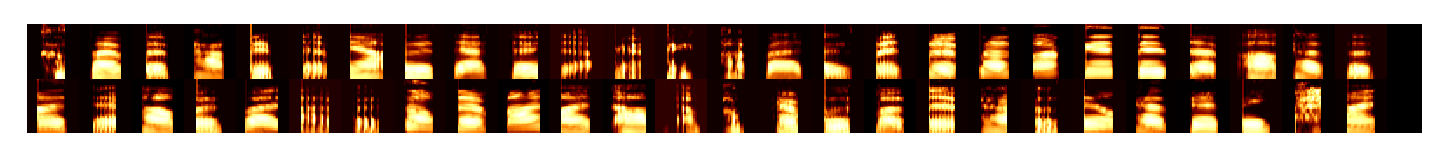

ih


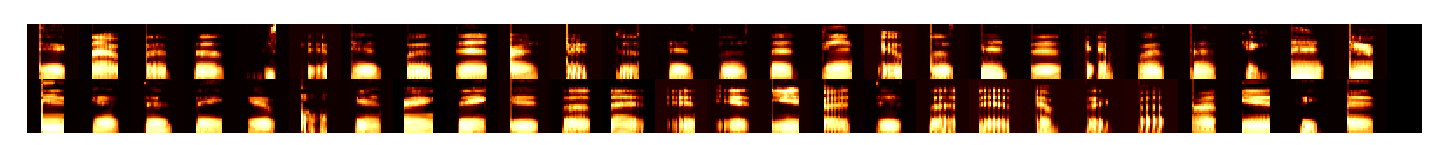

n


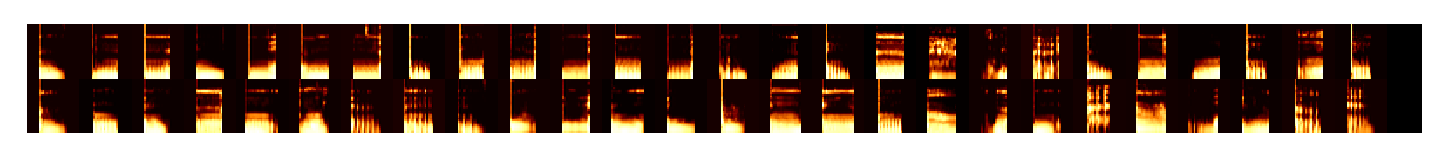

s


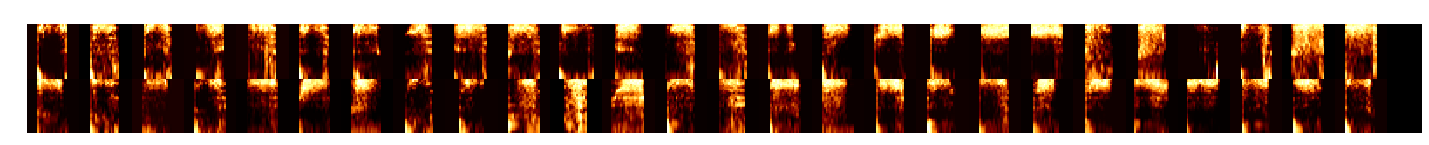

eh


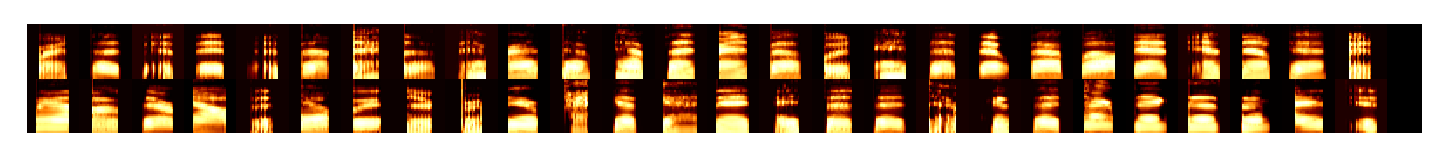

t


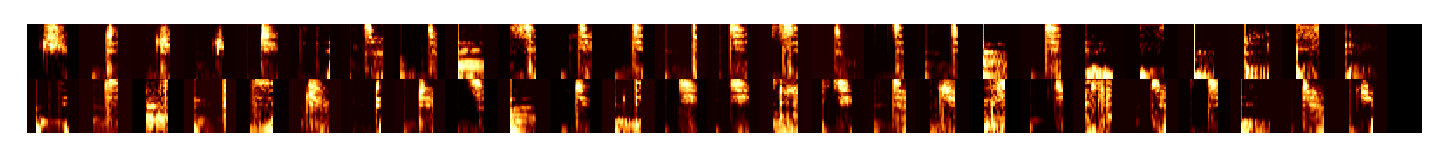

iy


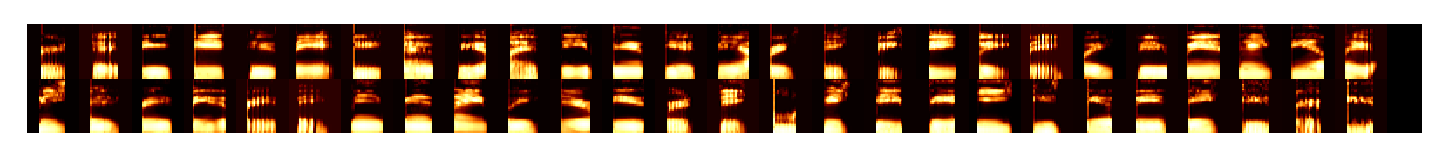

r


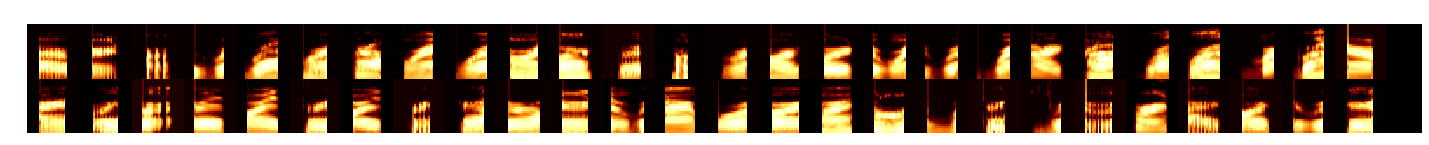

k


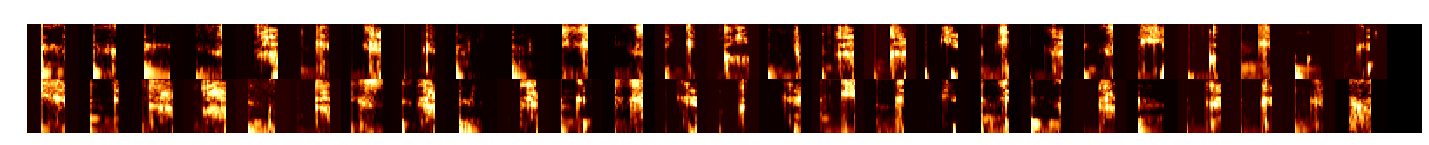

l


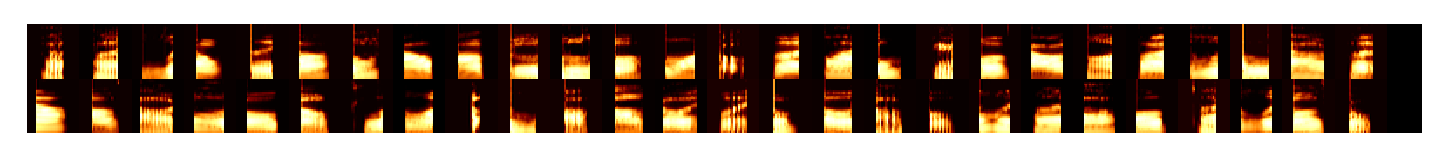

m


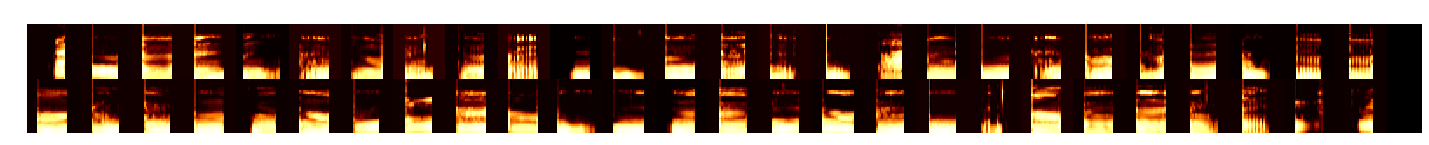

d


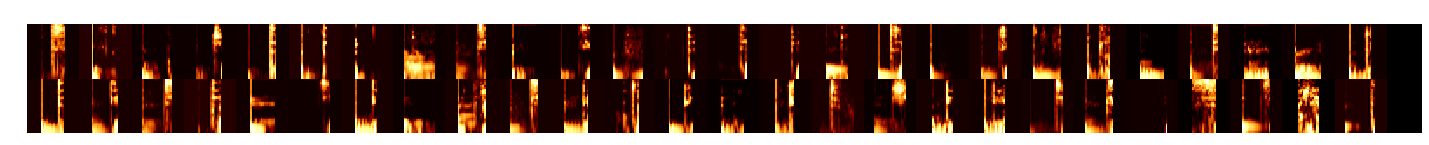

ay


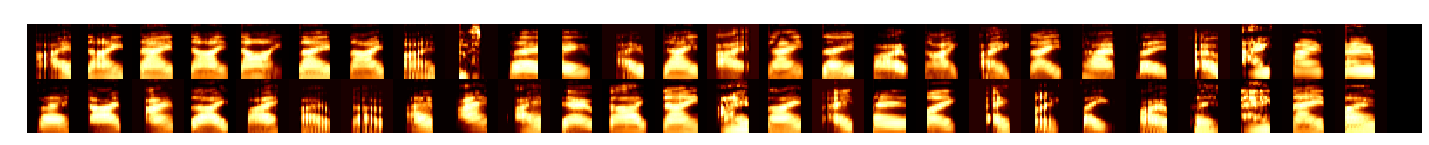

w


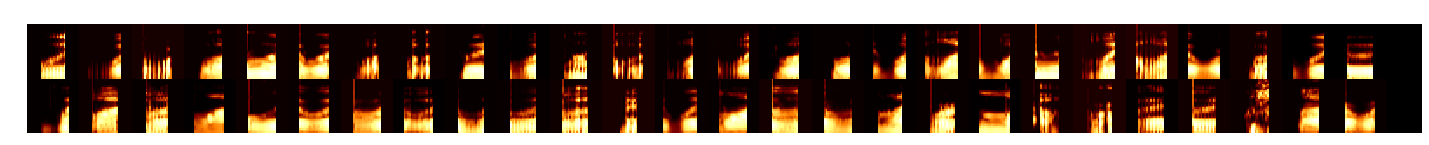

dh


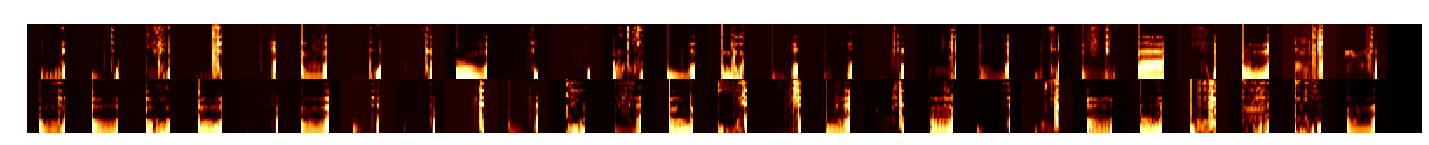

In [14]:
for word in tqdm(freq_words):
    subset_df = syllable_df[
        syllable_df.labels == word
    ]
    specs = list(subset_df.spectrogram.values)
    specs = [i/np.max(i) for i in specs]
    print(word)
    draw_spec_set(specs, zoom=1, maxrows=2, colsize=25)

In [15]:
subset_df = syllable_df[
    syllable_df.labels.isin(freq_words.columns)
]

In [16]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(528154, 960)

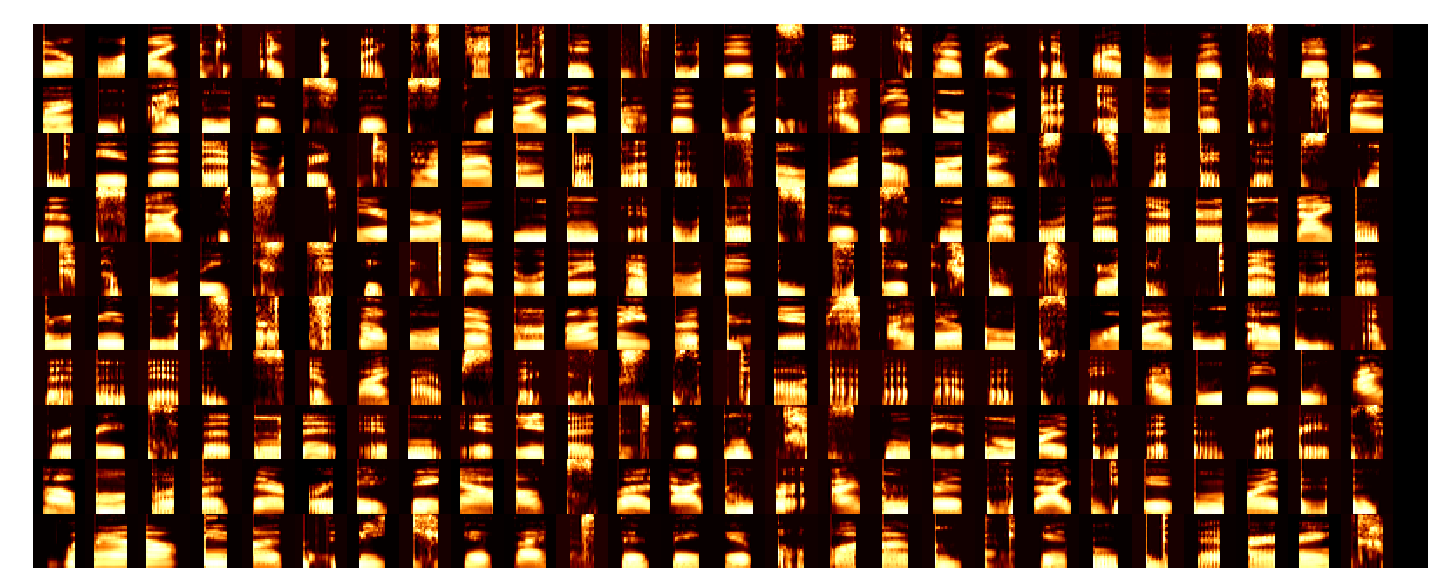

In [17]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [18]:
subset_df[:3]

,start_time,end_time,labels,word,utterance_number,position_in_utterance,position_in_word,word_number,indv,indvi,age,sex,key,audio,rate,spectrogram
0,4.885333,4.988600,w,well,0,0,0,0,s07,0,o,f,s0702b,"[-0.01725538584843273, -0.014406834034244777, ...",16000,"[[2, 2, 2, 2, 2, 2, 2, 0, 44, 79, 95, 86, 81, ..."
1,4.988600,5.114649,eh,well,1,0,1,0,s07,0,o,f,s0702b,"[0.6202093932054022, 0.6635785527737617, 0.653...",16000,"[[4, 4, 4, 4, 4, 174, 166, 164, 162, 160, 159,..."
2,5.114649,5.255262,l,well,2,0,2,0,s07,0,o,f,s0702b,"[-1.0220360017116719, -0.9509200687473669, -0....",16000,"[[5, 5, 5, 5, 5, 170, 156, 156, 154, 151, 149,..."


#### cluster and plot

In [19]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [20]:
fit = umap.UMAP()

In [21]:
np.shape(specs_flattened)

(528154, 960)

In [22]:
z  = list(fit.fit_transform(specs_flattened))

In [23]:
z = np.vstack(z)

### variation across populations

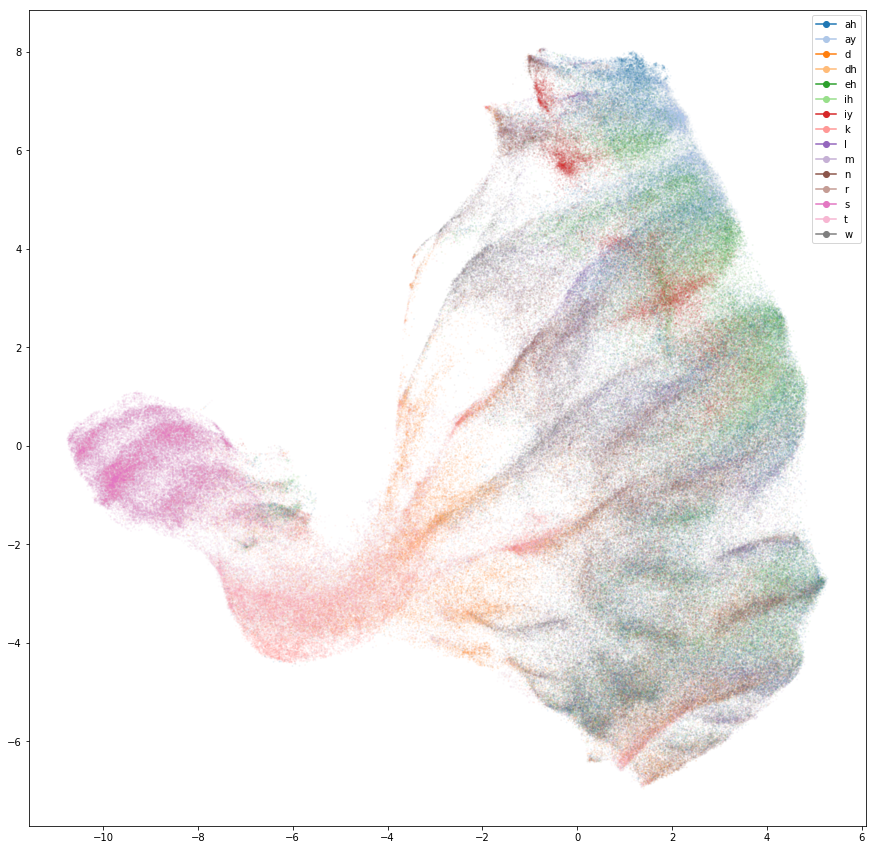

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=0.05, labels = subset_df.labels.values, s=1, ax = ax)

### draw transitions by population